In [1]:
import numpy as np
import casadi as ca
import matplotlib.pyplot as plt
import Simulation_wells as sw
from matplotlib.lines import Line2D

In [2]:


par_values = [
    0.5,     # wgl1
    0.7,     # wgl2
    1,     # u1
    1,     # u2
    0.02,     # GOR1
    0.02     # GOR2
]

# --- Condições Iniciais [m_ga1, m_ga2, m_gt1, m_gt2, m_ot1, m_ot2, m_gr, m_or] ---
y0 = [2000, 2000, 1000, 1500,
                           3500, 3500, 117.97660766, 795.94318092]

# --- Configuração do Tempo ---
t0 = 0
tf = 25000  # Tempo final [s]
dt = 5      # Passo de tempo [s]
t = np.arange(t0, tf, dt)

# --- Configuração do Integrador CasADi ---
x_sym = ca.SX.sym('x', 8)  # Vetor de 8 estados
par_sym = ca.SX.sym('par', 6) # Vetor de 6 parâmetros

# Define a expressão da EDO
dx_sym = sw.fun(0, x_sym, par_sym)

#Cria o integrador
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)


x_current = np.array(y0)
results = {key: [] for key in sw.modelo(y0, par_values).keys()}


for ti in t:

    res = integrator(x0=x_current, p=par_values)
    x_next = res['xf'].full().flatten()

    model_output = sw.modelo(x_next, par_values)
    
    for key in results:
        results[key].append(float(model_output[key]))
    
    x_current = x_next

for key in results:
    results[key] = np.array(results[key])


#

CasADi - 2025-07-31 14:16:38 WARNING("The options 't0', 'tf', 'grid' and 'output_t0' have been deprecated.
The same functionality is provided by providing additional input arguments to the 'integrator' function, in particular:
 * Call integrator(..., t0, tf, options) for a single output time, or
 * Call integrator(..., t0, grid, options) for multiple grid points.
The legacy 'output_t0' option can be emulated by including or excluding 't0' in 'grid'.
Backwards compatibility is provided in this release only.") [.../casadi/core/integrator.cpp:515]


--- Calculando mapa para GOR1 = 0.010 ---
no paremtro 0.2 e na taxa 0.2 o delta achado foi de 9.982841220335104e-10
no paremtro 0.30000000000000004 e na taxa 0.2 o delta achado foi de 9.965503977582557e-10
no paremtro 0.4 e na taxa 0.2 o delta achado foi de 7.884608521635528e-10
no paremtro 0.5 e na taxa 0.2 o delta achado foi de 3.934985670639435e-11
no paremtro 0.6000000000000001 e na taxa 0.2 o delta achado foi de 1.9547030660760356e-10
0.7 0.2
0.8 0.2
0.9000000000000001 0.2
1.0 0.2
no paremtro 0.2 e na taxa 0.4 o delta achado foi de 9.971472536562942e-10
no paremtro 0.30000000000000004 e na taxa 0.4 o delta achado foi de 9.929408406605944e-10
no paremtro 0.4 e na taxa 0.4 o delta achado foi de 6.649116812695866e-10
no paremtro 0.5 e na taxa 0.4 o delta achado foi de 2.9666580303455703e-10
no paremtro 0.6000000000000001 e na taxa 0.4 o delta achado foi de 3.346940502524376e-10
no paremtro 0.7 e na taxa 0.4 o delta achado foi de 4.53894699603552e-10
0.8 0.4
0.9000000000000001 0.4
1.0

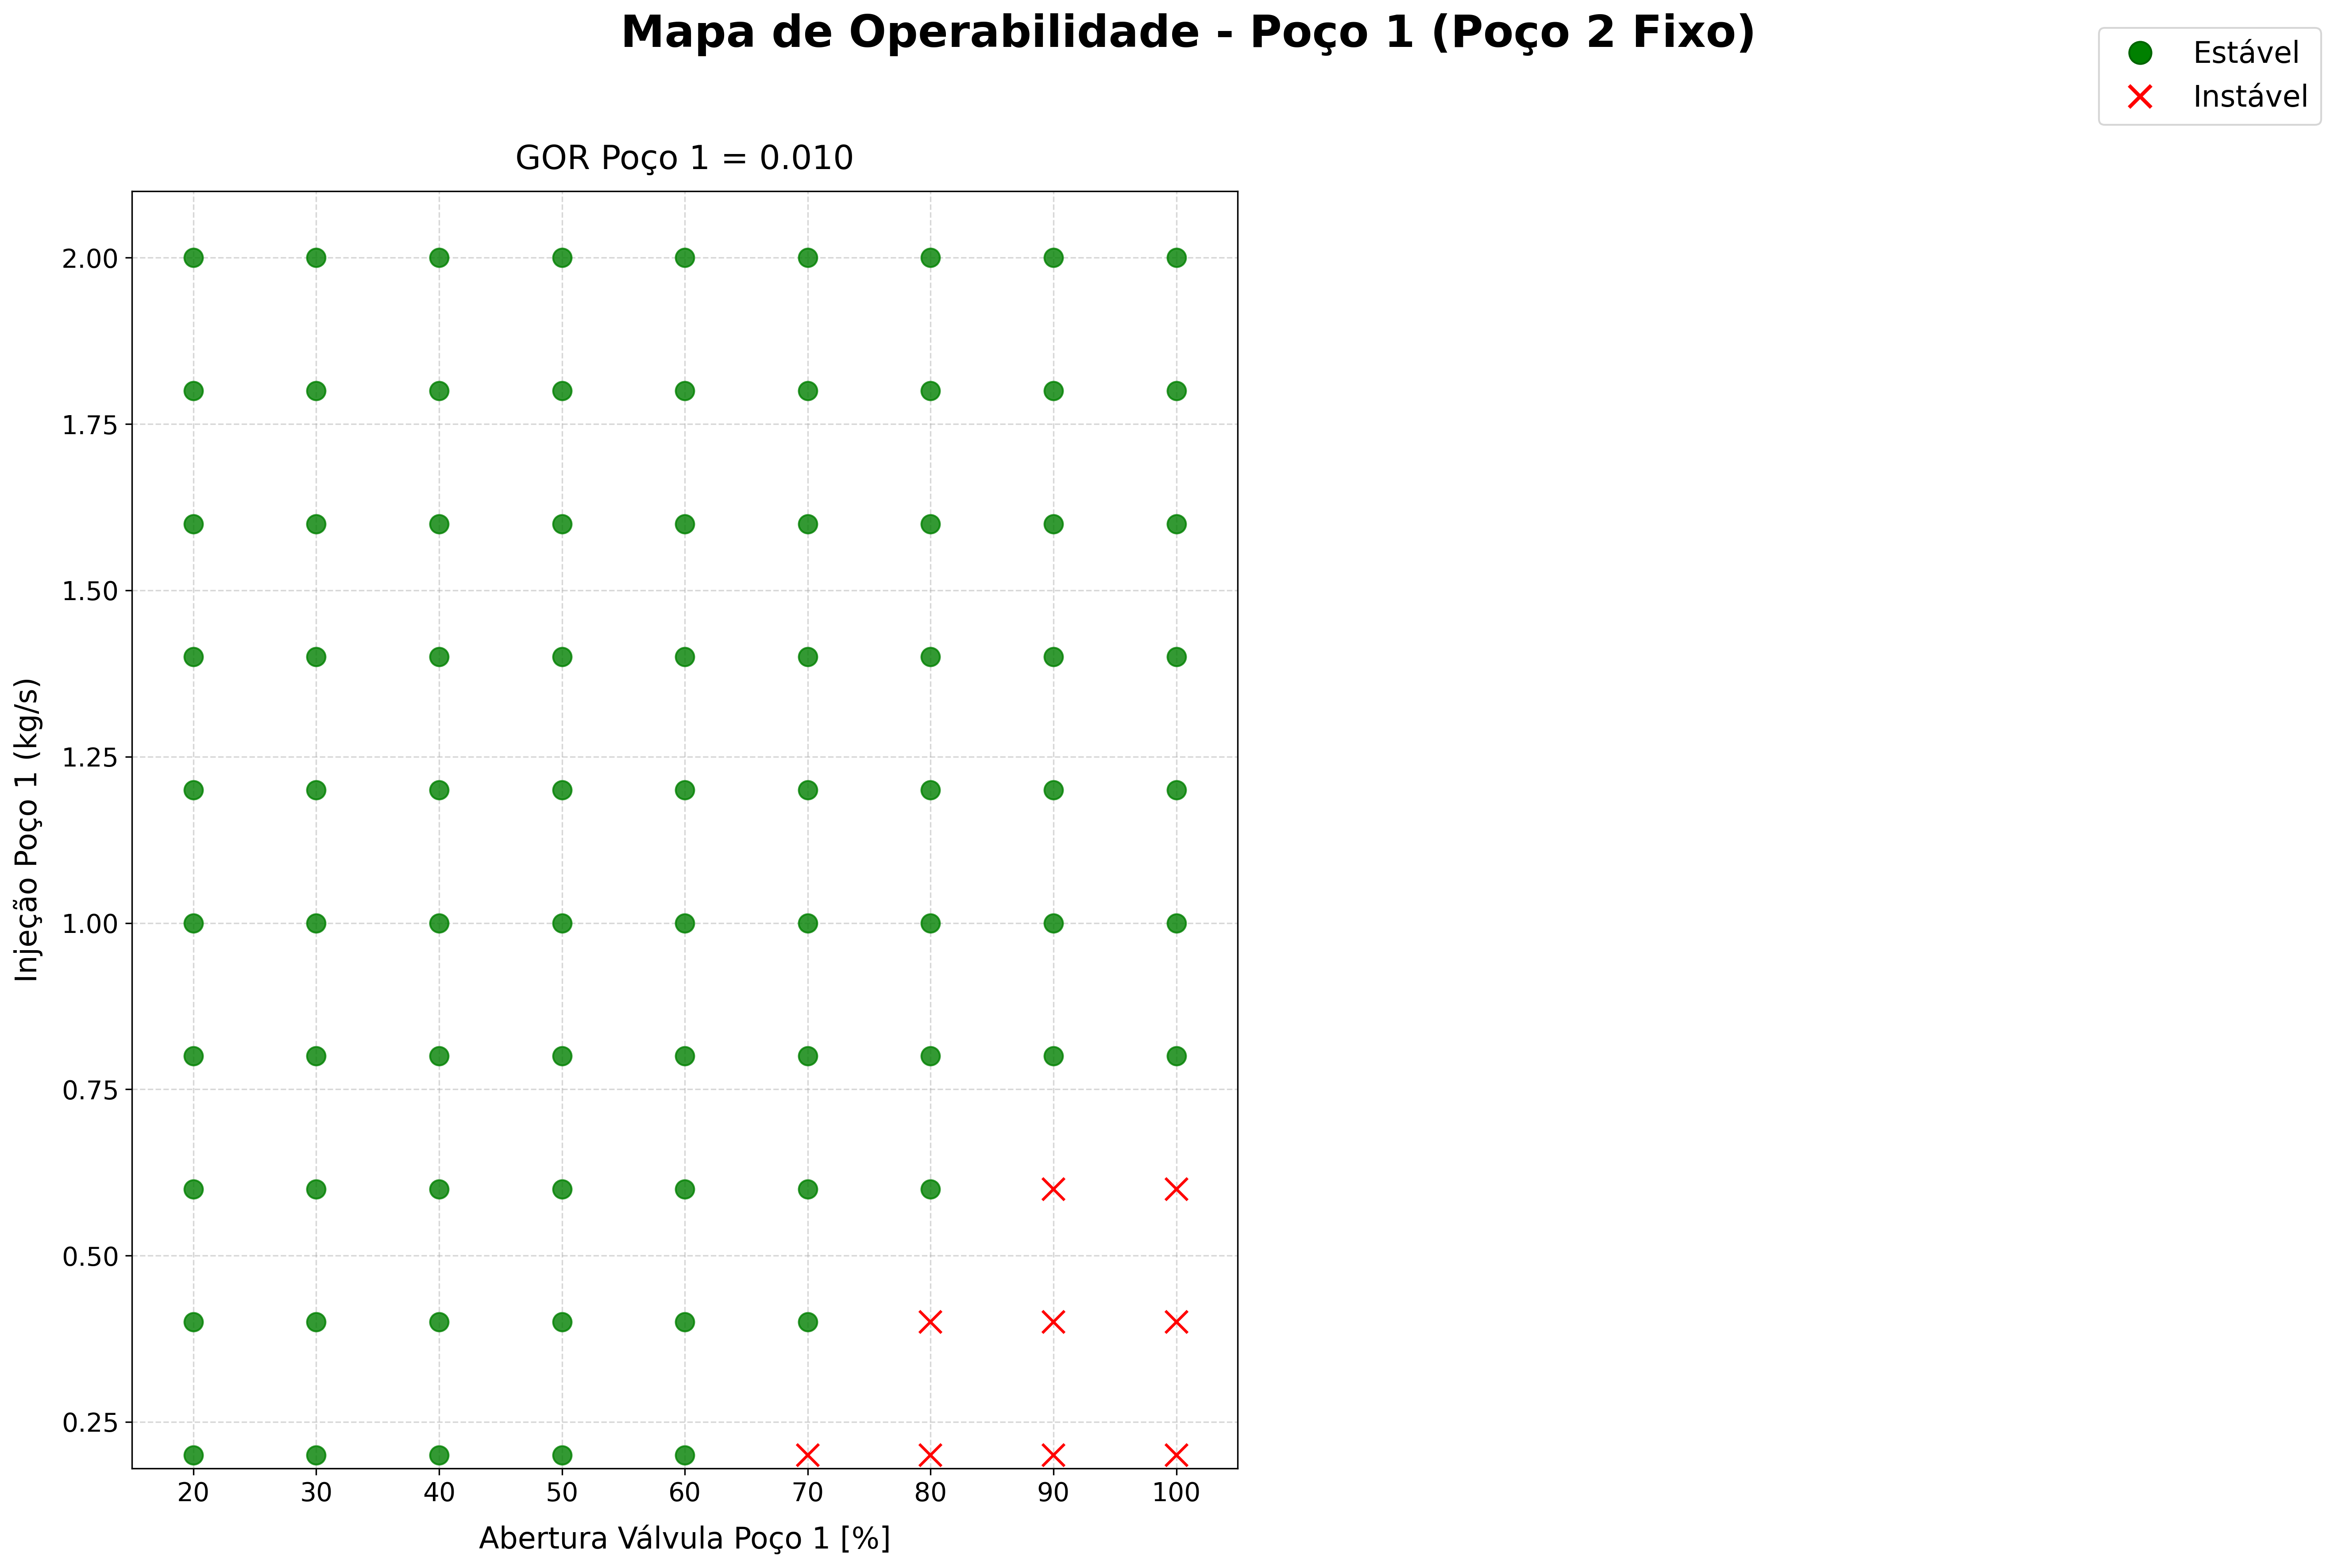

In [24]:
wgl1_rates = np.linspace(0.2, 2.0, 10)      
u1_openings = np.linspace(0.2, 1.0, 9)     
GOR1_values = [0.01]#, 0.03]#, 0.05, 0.08]      

# Parâmetros FIXOS para o Poço 2 
wgl2_fixed = 0.7   
u2_fixed = 1.0     
GOR2_fixed = 0.1  

# [m_ga1, m_ga2, m_gt1, m_gt2, m_ot1, m_ot2, m_gr, m_or] ---
y0 = [2000, 2000, 1000, 1500, 3500, 3500, 117.97, 795.94]

# --- Configuração do Tempo e Critério de Convergência ---
tf = 30000         # Tempo final da simulação para cada ponto [s]
dt = 1           # Passo de tempo [s]
t = np.arange(0, tf, dt)
tolerance = 1e-9# Tolerância para considerar o sistema estável (variação na massa de gás)


x_sym = ca.SX.sym('x', 8)
par_sym = ca.SX.sym('par', 6)

dx_sym = sw.fun(0, x_sym, par_sym)
dae = {'x': x_sym, 'p': par_sym, 'ode': dx_sym}
opts = {'tf': dt}
integrator = ca.integrator('integrator', 'rk', dae, opts)

# Configuração da Figura para os Mapas

n_gor = len(GOR1_values)

ncols = 2
nrows = int(np.ceil(n_gor / ncols))

# --- Cria a figura com alta resolução (DPI) ---
fig, axs = plt.subplots(nrows, ncols, figsize=(18, 12), dpi=300,sharex=True, sharey=True)
axs = np.array(axs).flatten()

fig.suptitle('Mapa de Operabilidade - Poço 1 (Poço 2 Fixo)', fontsize=24, weight='bold')

passos = 3
contador = 0

for idx, gor1_val in enumerate(GOR1_values):
    print(f"--- Calculando mapa para GOR1 = {gor1_val:.3f} ---")
    stability_map = np.zeros((len(wgl1_rates), len(u1_openings)))

    for i, wgl1 in enumerate(wgl1_rates):
        for j, u1 in enumerate(u1_openings):
            par_values = [wgl1, wgl2_fixed, u1, u2_fixed, gor1_val, GOR2_fixed]
            x_current = np.array(y0)
            stable_found = False

            for ti in t:
                res = integrator(x0=x_current, p=par_values)
                x_next = res['xf'].full().flatten()

               
                delta = np.abs( x_current[6] - x_next[6])


                if delta <= tolerance:
                    contador += 1  
                else:
                    contador = 0   
                if contador >= passos:
                    stable_found = True
                  
                    break
                    
                x_current = x_next
            
            stability_map[i, j] = 1 if stable_found else 0
            if stability_map[i,j] == 1:
                print(f'no paremtro {u1} e na taxa {wgl1} o delta achado foi de {delta}')
            if stability_map[i,j] == 0:
               
                print(u1,wgl1)
    ax = axs[idx]
    for i, wgl1 in enumerate(wgl1_rates):
        for j, u1 in enumerate(u1_openings):
            u1_pct = u1 * 100
            if stability_map[i, j] == 1:
                ax.plot(u1_pct, wgl1, 'o', color='green', markersize=10, alpha=0.8)
            else:
                ax.plot(u1_pct, wgl1, 'x', color='red', markersize=12, mew=1.5)

    ax.set_title(f"GOR Poço 1 = {gor1_val:.3f}", fontsize=18, pad=12)
    ax.grid(True, linestyle='--', alpha=0.5)
    ax.set_xlim(15, 105)
    ax.set_ylim(wgl1_rates[0] * 0.9, wgl1_rates[-1] * 1.05)
    ax.tick_params(axis='both', labelsize=14)

for ax in axs.flat:
    ax.set_xlabel("Abertura Válvula Poço 1 [%]", fontsize=16, labelpad=10)
    ax.set_ylabel("Injeção Poço 1 (kg/s)", fontsize=16, labelpad=10)

for k in range(idx + 1, len(axs)):
    fig.delaxes(axs[k])

legend_elements = [
    Line2D([0], [0], marker='o', color='w', label='Estável',
           markerfacecolor='green', markersize=12, markeredgecolor='darkgreen'),
    Line2D([0], [0], marker='x', color='red', label='Instável',
           markersize=12, mew=2, linestyle='None')
]
fig.legend(handles=legend_elements, loc='upper right', fontsize=16, bbox_to_anchor=(0.98, 0.98))

plt.tight_layout(rect=[0, 0, 1, 0.95])
plt.show()
